# Kings County Housing Prices Bakeoff

In [182]:
import pandas as pd
import numpy as np
from statsmodels.formula.api import ols
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# web scraper
from bs4 import BeautifulSoup
import requests
import sys
import time
time.sleep(5)
from geopy.distance import geodesic
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="ameliadahm@gmail.com")
# sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [201]:
page = requests.get("https://www.publicschoolreview.com/washington/king-county")
page.status_code

200

In [202]:
soup = BeautifulSoup(page.content, 'html.parser')

In [203]:
# school_name = []
# for item in soup.find_all(class_='tooltip'):
#     item = item.text
#     if not item.endswith(')'): # ends with ) means school is closed
#         school_name.append(item)

In [204]:
# # rank = list(range(1, 36))
# score = []
# for item in soup.find_all(class_='caption captionwidth'):
#     item = item.text
#     if item.endswith('%'):
#         score.append(item[-2:])

In [205]:
# school_rank = [{'Name': b, 'Rank': a} for (a, b) in zip(rank, school_name)]

In [206]:
address = []
for item in soup.find_all(class_='table_cell_county'):
    item = item.text[:-14]
    address.append(item.strip())
for item in address:
    if item == '':
        address.remove(item)
address = address[:35]

In [207]:
latitude = []
longitude = []
for item in address:
    location = geolocator.geocode(item)
    if location != None:
        latitude.append(location.latitude) 
        longitude.append(location.longitude)

In [208]:
school_coordinates = [{'lat': a, 'long': b} for (a, b) in zip(latitude, longitude)]

In [209]:
school_coordinates = pd.DataFrame.from_dict(school_coordinates)

In [210]:
# # 22 schools that fall in the top 35 schools in the county
# school_coordinates

In [211]:
# house distance to a top school
def get_distance(lat, long):
    miles = []
    for i in range(23):
        school = school_coordinates.loc[i]
        miles.append(geodesic((lat,long), school).miles)
    return min(miles)

# return sum(miles)/len(miles)


In [245]:
get_distance(47.43, -122.162)

8.93331252458849

## Step 1: Read in the Data

In [251]:
# Read in CSV and drop unneeded columns
df = pd.read_csv('kc_house_data_train.csv')
df = df.drop(columns=['Unnamed: 0', 'id'])

# View all columns
pd.set_option('display.max_columns', 25)

In [252]:
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,20141006T000000,365000.0,4,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700
1,20140821T000000,865000.0,5,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283
2,20140815T000000,1038000.0,4,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685
3,20150331T000000,1490000.0,3,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226
4,20140714T000000,711000.0,3,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050


In [253]:
# FORMATTING DATE: adding year, month, and day columns
df['date'] = df['date'].str.slice(0, 8, 1)
df['year_sold'] = df['date'].str.slice(0, 4, 1)
df['month_sold'] = df['date'].str.slice(4, 6, 1)
df['day_sold'] = df['date'].str.slice(6, 8, 1)
df['date_sold'] = df['year_sold'] + '-' + df['month_sold'] + '-' + df['day_sold']

In [254]:
# Adjusting dtypes and dropping original data column
df['date_sold'] = pd.to_datetime(df['date_sold'])
df['year_sold'] = df['year_sold'].astype('int64')
df['month_sold'] = df['month_sold'].astype('int64')
df['day_sold'] = df['day_sold'].astype('int64')
df = df.drop(columns='date')

In [255]:
# replace 0 with yr_built so it doesnt think zero is a year -- last time the house was updated
df['yr_renovated'] = df['yr_renovated'].replace(0, df['yr_built'])

In [256]:
df

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year_sold,month_sold,day_sold,date_sold
0,365000.0,4,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,1986,98058,47.4388,-122.162,2390,7700,2014,10,6,2014-10-06
1,865000.0,5,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,1977,98115,47.6784,-122.285,2370,6283,2014,8,21,2014-08-21
2,1038000.0,4,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,1997,98006,47.5646,-122.129,3710,9685,2014,8,15,2014-08-15
3,1490000.0,3,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,1990,98034,47.6995,-122.228,4050,14226,2015,3,31,2015-03-31
4,711000.0,3,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,2004,98052,47.6647,-122.083,2250,4050,2014,7,14,2014-07-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17285,750000.0,5,2.50,3240,9960,1.0,0,1,3,8,2020,1220,1958,1958,98008,47.5858,-122.112,2730,10400,2015,3,3,2015-03-03
17286,440000.0,2,1.75,1300,4000,2.0,0,0,3,7,1300,0,1948,1948,98105,47.6687,-122.288,1350,4013,2014,5,20,2014-05-20
17287,310000.0,3,1.00,1050,9876,1.0,0,0,3,7,1050,0,1953,1953,98028,47.7635,-122.262,1760,9403,2014,5,14,2014-05-14
17288,427500.0,3,1.50,1900,43186,1.5,0,0,4,7,1300,600,1971,1971,98038,47.4199,-121.990,2080,108028,2014,12,4,2014-12-04


In [257]:
df.yr_renovated.value_counts()

2014    524
2004    379
2005    376
2007    367
2006    364
       ... 
1901     24
1902     21
1933     20
1935     15
1934     13
Name: yr_renovated, Length: 116, dtype: int64

In [258]:
# df[['yr_built', 'yr_renovated']]
df['was_renovated'] = (df['yr_renovated'] - df['yr_built'])

In [259]:
df['years_updated'] = (2020 - df['yr_renovated'])

In [260]:
df.was_renovated.value_counts()

0      16564
43        18
32        17
63        16
37        16
       ...  
39         1
113        1
109        1
10         1
16         1
Name: was_renovated, Length: 103, dtype: int64

In [261]:
df.sort_values(by=['year_sold'])

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year_sold,month_sold,day_sold,date_sold,was_renovated,years_updated
0,365000.0,4,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,1986,98058,47.4388,-122.162,2390,7700,2014,10,6,2014-10-06,0,34
10380,489000.0,2,1.75,1810,4220,2.0,0,0,3,8,1810,0,2004,2004,98053,47.7177,-122.034,1350,4479,2014,8,26,2014-08-26,0,16
10382,459950.0,4,2.50,2000,6107,2.0,0,0,3,8,2000,0,2003,2003,98011,47.7557,-122.221,2040,6520,2014,6,23,2014-06-23,0,17
10385,409950.0,3,1.75,1320,6030,1.0,0,0,4,7,1320,0,1969,1969,98052,47.6993,-122.130,1840,6565,2014,7,15,2014-07-15,0,51
10386,383000.0,3,2.25,2090,15000,1.0,0,0,3,7,2090,0,1961,1961,98045,47.4885,-121.783,1690,14400,2014,7,8,2014-07-08,0,59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4264,221347.0,3,2.00,1580,6655,1.0,0,0,3,6,790,790,1944,1944,98178,47.4927,-122.248,1090,6655,2015,2,18,2015-02-18,0,76
13446,419900.0,3,1.50,1450,7000,1.0,0,0,3,7,1450,0,1955,1955,98007,47.5983,-122.150,1490,7245,2015,2,4,2015-02-04,0,65
13445,302100.0,3,1.00,1790,6120,1.0,0,0,3,6,1790,0,1937,1964,98146,47.5080,-122.337,830,6120,2015,4,24,2015-04-24,27,56
13465,367000.0,4,2.50,2960,6219,2.0,0,0,3,9,2960,0,2006,2006,98038,47.3603,-122.037,2960,5361,2015,3,6,2015-03-06,0,14


In [262]:
df.year_sold.value_counts()

2014    11703
2015     5587
Name: year_sold, dtype: int64

In [263]:
df[df.bedrooms == 33]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year_sold,month_sold,day_sold,date_sold,was_renovated,years_updated
8597,640000.0,33,1.75,1620,6000,1.0,0,0,5,7,1040,580,1947,1947,98103,47.6878,-122.331,1330,4700,2014,6,25,2014-06-25,0,73


In [264]:
# updating incorrect value
df.at[8597,'bedrooms']= 3

In [274]:
# df['top_school_distance'] = get_distance(df['lat'], df['long'])
#

In [275]:
# df['top_school_distance'] = df[['lat', 'long']].apply(get_distance, axis=1)


## Step 2: Exploratory Data Analysis
Become familiar with the data. Look to see if there are any extreme values.

Additionally create data visualizations to determine if there are any relationships between your features and your target variables.

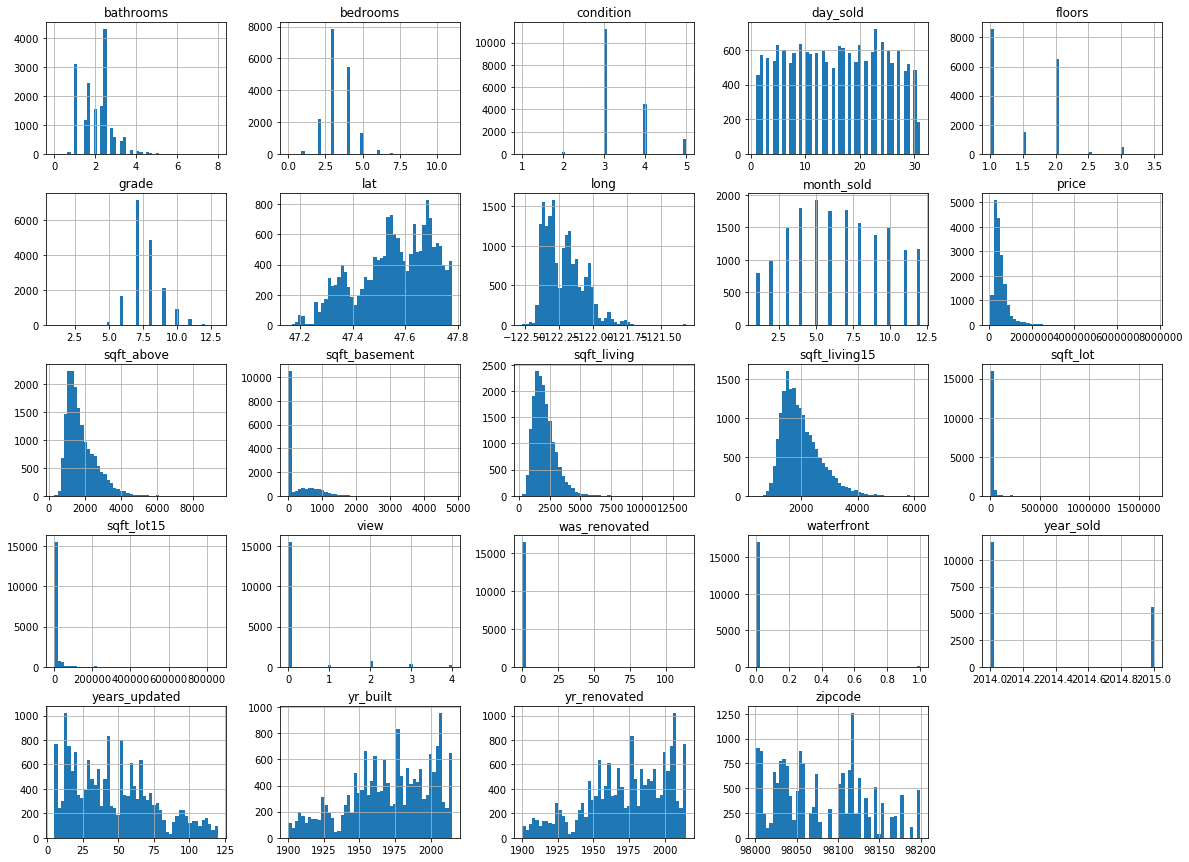

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
df.hist(bins=50, figsize=(20,15))
plt.show()

In [25]:
# added different features to mutiple linear regression and seeing how it affects the r-squared value

In [26]:
test_model = ols(formula='price~bedrooms+bathrooms+sqft_living+grade+waterfront+view+yr_built+yr_renovated+sqft_living15', data=df).fit()
test_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     3585.
Date:                Sun, 18 Oct 2020   Prob (F-statistic):               0.00
Time:                        15:39:58   Log-Likelihood:            -2.3726e+05
No. Observations:               17290   AIC:                         4.745e+05
Df Residuals:                   17280   BIC:                         4.746e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      6.612e+06   1.42e+05     46.417      0.000    6.33e+06    6.89e+06
bedrooms      -4.171e+04   2370.092    -17.596      0.000   -4.64e+04   -3.71e+04
bathrooms      5.676e+04   3836.898     14.794      0.000    4.92e+04    6.43e+04
sqft_living     164.6055      4.043     40.714      0.000     156.681     172.530
grade          1.229e+05   2509.815     48.955      0.000    1.18e+05    1.28e+05
waterfront     5.934e+05   2.07e+04     28.665      0.000    5.53e+05    6.34e+05
view           4.225e+04   2518.226     16.776      0.000    3.73e+04    4.72e+04
yr_built      -3719.5806    140.553    -26.464      0.000   -3995.079   -3444.082
yr_renovated    -29.8480    144.769     -0.206      0.837    -313.611     253.914
sqft_living15    20.3433      4.011      5.072      0.000      12.481      28.206
==============================================================================
Omnibus:                    13480.468   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1075829.367
Skew:                           3.157   Prob(JB):                         0.00
Kurtosis:                      41.125   Cond. No.                     3.47e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.47e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [27]:
X = df[['bedrooms', 'bathrooms', 'sqft_living', 'grade', 'waterfront', 'view', 'yr_built', 'yr_renovated', 'sqft_living15']] #predictors as x
y = df['price'] # target as y

X_train, X_test, y_train, y_test = train_test_split(X, y,               # Pass in our X and y
                                                    random_state=42,    # Abritary select a random_state 
                                                    test_size=.2        # Split test size to be 20% of full data.
                                                   )

# Instantiate MinMaxScaler object
# lots of different ways to scale our data
minmax = MinMaxScaler()

# # Fit and Transform the training data.
X_train_transformed = minmax.fit_transform(X_train)

# # ONLY TRANSFORM the test data.
# #------- NEVER fit
X_test_transformed = minmax.transform(X_test)

# # Instantiate the Linear Regression Object.
model = LinearRegression()

# # Fit the model to the transformed X_train, and the y_train.
model.fit(X_train_transformed, y_train)

# # Score the model based on the transformed X_test and the y_test.
model.score(X_test_transformed, y_test)

0.6540169648002794

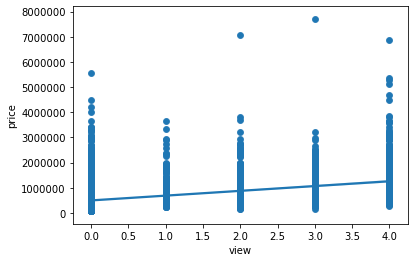

In [28]:

df.plot.scatter(x='view', y='price');
sns.regplot(data=df, x='view', y='price');

In [29]:
df.corr()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year_sold,month_sold,day_sold,was_renovated,years_updated
price,1.000000,0.313775,0.524335,0.703540,0.086803,0.256985,0.275779,0.395485,0.036099,0.666215,0.607760,0.323312,0.056450,0.104812,-0.048958,0.302394,0.019327,0.585567,0.081423,-0.002334,-0.004350,-0.017157,0.110724,-0.104812
bedrooms,0.313775,1.000000,0.524033,0.588536,0.030674,0.179908,-0.008668,0.082724,0.021376,0.366405,0.488420,0.307873,0.159936,0.168762,-0.152831,-0.003991,0.129593,0.401073,0.028038,-0.010211,0.002985,-0.011463,0.013672,-0.168762
bathrooms,0.524335,0.524033,1.000000,0.755270,0.085470,0.497967,0.065848,0.188817,-0.122976,0.664191,0.686853,0.282700,0.507761,0.536815,-0.201527,0.023074,0.221308,0.568080,0.086499,-0.030045,0.012950,-0.000155,0.045823,-0.536815
sqft_living,0.703540,0.588536,0.755270,1.000000,0.166810,0.357169,0.109738,0.283336,-0.061530,0.762929,0.876696,0.435529,0.319397,0.342839,-0.195893,0.052646,0.234453,0.755066,0.179570,-0.033606,0.017737,-0.009618,0.040917,-0.342839
sqft_lot,0.086803,0.030674,0.085470,0.166810,1.000000,-0.002205,0.015356,0.073058,-0.013715,0.110320,0.180755,0.008065,0.054228,0.052918,-0.126590,-0.082029,0.226190,0.136959,0.701875,0.003141,-0.001722,0.004204,-0.005434,-0.052918
floors,0.256985,0.179908,0.497967,0.357169,-0.002205,1.000000,0.025132,0.025883,-0.259230,0.458984,0.528509,-0.247481,0.483657,0.498899,-0.060560,0.048227,0.128795,0.283933,-0.008170,-0.024641,0.019629,-0.000914,0.014548,-0.498899
waterfront,0.275779,-0.008668,0.065848,0.109738,0.015356,0.025132,1.000000,0.407565,0.009608,0.092234,0.077162,0.083433,-0.021981,0.005262,0.034282,-0.013331,-0.042728,0.091090,0.026895,-0.000824,0.005685,0.012574,0.064721,-0.005262
view,0.395485,0.082724,0.188817,0.283336,0.073058,0.025883,0.407565,1.000000,0.045060,0.249554,0.164747,0.279939,-0.049593,-0.020531,0.089475,0.003820,-0.077572,0.279999,0.073185,0.000701,-0.004189,0.013054,0.070185,0.020531
condition,0.036099,0.021376,-0.122976,-0.061530,-0.013715,-0.259230,0.009608,0.045060,1.000000,-0.142066,-0.157466,0.166923,-0.358921,-0.392758,0.007068,-0.009927,-0.109200,-0.094307,-0.007125,-0.044871,0.017099,-0.006111,-0.063519,0.392758
grade,0.666215,0.366405,0.664191,0.762929,0.110320,0.458984,0.092234,0.249554,-0.142066,1.000000,0.758247,0.165003,0.448003,0.458830,-0.184946,0.116196,0.198369,0.715745,0.116062,-0.036560,0.015166,-0.009128,0.005772,-0.458830


In [30]:
df.sqft_living.describe()

count    17290.000000
mean      2081.464604
std        920.018539
min        290.000000
25%       1430.000000
50%       1920.000000
75%       2550.000000
max      13540.000000
Name: sqft_living, dtype: float64

In [31]:
df.sqft_living.quantile(q=.75)

2550.0

In [32]:
df.loc[df.was_renovated > 0, 'was_renovated'] = 1

In [33]:
df[df['was_renovated'] != 0]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year_sold,month_sold,day_sold,date_sold,was_renovated,years_updated
11,385000.0,3,1.75,1930,14389,1.0,0,0,3,7,1130,800,1963,1998,98155,47.7733,-122.317,1730,14378,2015,3,3,2015-03-03,1,22
33,250000.0,3,2.25,1640,4420,2.0,0,0,4,7,1640,0,1918,1983,98002,47.3110,-122.210,1230,6632,2014,10,24,2014-10-24,1,37
67,1225000.0,4,2.50,3120,49456,2.0,1,4,4,9,2590,530,1974,1989,98198,47.3535,-122.323,2030,32181,2014,10,28,2014-10-28,1,31
186,174950.0,2,1.00,730,6000,1.0,0,0,3,6,730,0,1950,1985,98198,47.3832,-122.300,1750,7200,2014,12,8,2014-12-08,1,35
227,900000.0,6,2.75,2300,24773,1.5,0,0,4,9,2300,0,1950,1985,98040,47.5833,-122.242,2720,11740,2014,5,28,2014-05-28,1,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17229,950000.0,3,2.50,3480,7800,1.0,0,0,4,7,1750,1730,1941,1998,98177,47.7047,-122.378,3010,9918,2014,7,8,2014-07-08,1,22
17235,430000.0,3,2.50,2000,35438,2.0,0,0,3,7,2000,0,1968,2005,98027,47.4733,-121.994,2000,51836,2015,3,31,2015-03-31,1,15
17239,335000.0,2,1.75,1660,11437,2.0,0,0,3,7,1660,0,1958,1992,98146,47.4899,-122.339,1290,7860,2014,8,13,2014-08-13,1,28
17248,808000.0,3,1.75,2590,32380,1.0,0,0,3,8,2590,0,1951,1994,98177,47.7539,-122.370,2340,28456,2014,9,23,2014-09-23,1,26


In [39]:
df[['lat','long']]

,lat,long
0,47.4388,-122.162
1,47.6784,-122.285
2,47.5646,-122.129
3,47.6995,-122.228
4,47.6647,-122.083
...,...,...
17285,47.5858,-122.112
17286,47.6687,-122.288
17287,47.7635,-122.262
17288,47.4199,-121.990


In [ ]:
# sns.heatmap
# heatmap on zip codes

## Step 3: Clean up any issues (extreme values, etc.) with the data.
Remember that you can't just delete rows with extreme values. Similar observations might be present in the holdout data set, and you can't just delete those rows and not have a prediction for it.

## Step 4: Generate new features that you think could be important.
After doing this, you will want to go back to steps 2 and 3 to investigate these new features.

### 4.1) Identify a categorical variable in the data set and create dummy columns.

### 4.2) There is a column that gives the date for when the house was sold, how could this be useful in your model? How might you transform the current column to a more useful feature?

### 4.3) There are columns for when the house was built and when it was renovated. How could you use these columns to create a new column?

### Non-linear transformations
### 4.4) Create a polynomial feature for two of your continuous variables.

### 4.5) Create an interaction feature between a binary variable (dummy variable) and a continuous variable.

## Step 5: Train-Test Split
If you plan on doing any scaling of your data, make sure it is done at the appropriate time.

# *USE A stratified split* 
sqft_living	has the highest correlation
break into quartiles

### 5.1) Perform a train-test split of the data.

### 5.2) Fit your scaler to training the data.

### 5.3) Transform the testing set with the scaler.

### 5.4) Fit the model to the training data.

### 5.5) Use the model to predict on the training set and the test set.

### 5.6) Evaluate the training and test predictions using RMSE.

### 5.7) Determine if your model is overfit.

## Step 6: Utilize some different feature selection techniques before or in conjuction with fitting your models.

### 6.1) Utilize a filter method to identify some features to remove from the model.

### 6.2) After removing the features, re-run Step 5 and see if your new model performs better than the old model.

## Step 7: Evaluate your different models in order to determine the best model overall.

## Step 8: Refit your best model to the entire dataset.

## Step 9: Save your final model using pickle.
https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/